### ДЗ 1. ARIMA

##### Дано: 
Набор данных. который содержит смоделированные временные ряды, охватывающие 10 лет (2010-2019). 

Файл train.csv охватывает 2010-2018 годы, а файл test.csv - только 2019 год. 

В данных 7 уникальных магазинов и 10 уникальных товаров. Пропущенных значений нет. 

##### Задача: 
Спрогнозировать продажи в test.csv с помощью моделей ARIMA или SARIMA.
##### Выполнить:

* Анализ данных
* Обработку данных
* Оценку качества модели с помощью анализа остатков модели
* Оценку качества предсказаний с помощью метрик mape, rmse, r2

Колонки с id магазина или id товара могут оказаться бесполезными, их разрешается удалить и работать только с колонкой продаж.

Разрешается менять гранулярность.


In [303]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pmdarima import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_white
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.stats import shapiro, normaltest

from pylab import rcParams
rcParams['figure.figsize'] = 10,5


Прочитаем данные, сразу сконвертировав даты.

In [304]:
train = pd.read_csv(r'C:\Users\user\Documents\Магистратура\Predictive\homework\train.csv', index_col = 'Date', parse_dates = True)
test = pd.read_csv(r'C:\Users\user\Documents\Магистратура\Predictive\homework\test.csv', index_col = 'Date', parse_dates = True)    

Проведеи первичный анализ данных

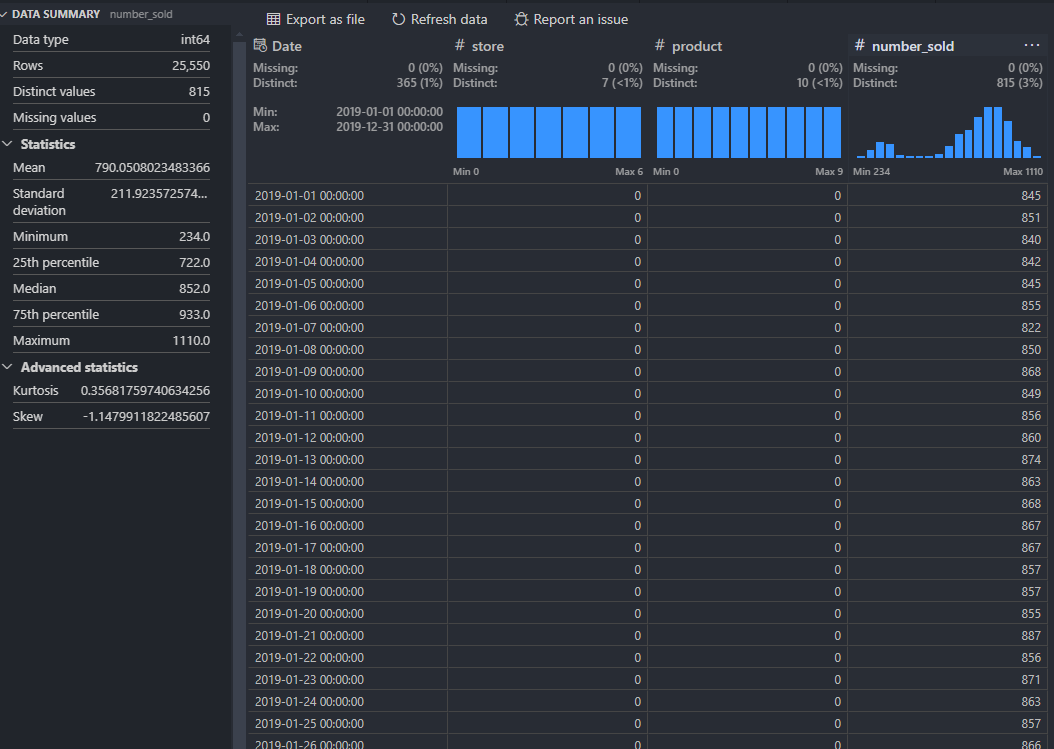
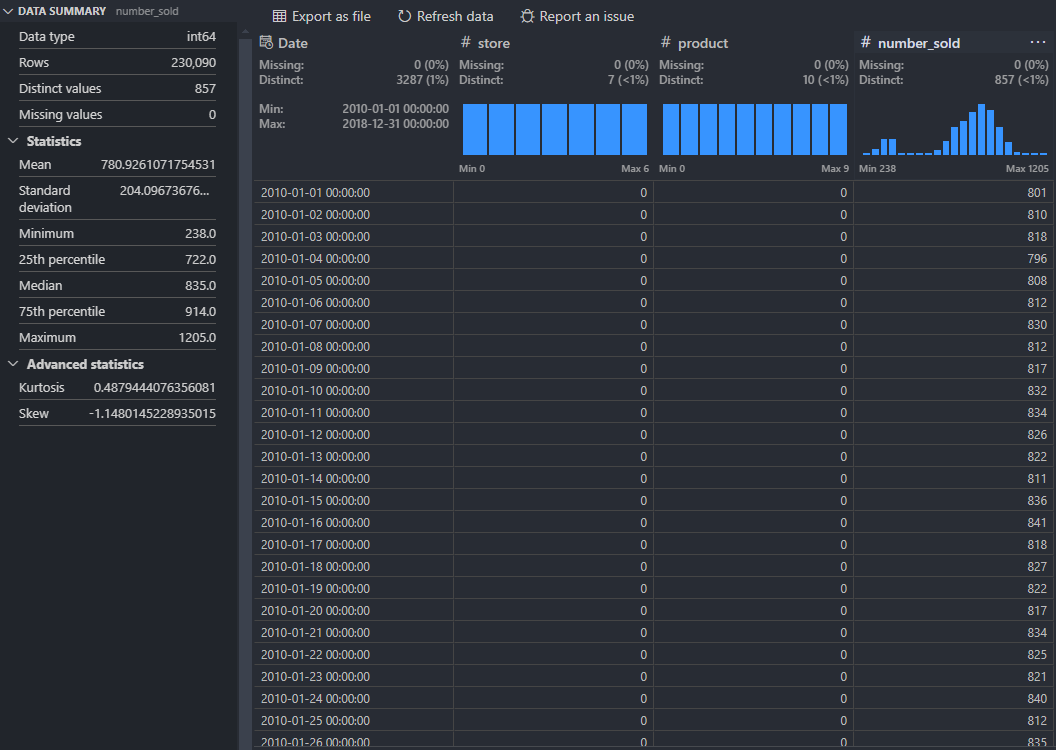

In [305]:
train.describe()

,store,product,number_sold
count,230090.000000,230090.000000,230090.000000
mean,3.000000,4.500000,780.926107
std,2.000004,2.872288,204.096737
min,0.000000,0.000000,238.000000
25%,1.000000,2.000000,722.000000
50%,3.000000,4.500000,835.000000
75%,5.000000,7.000000,914.000000
max,6.000000,9.000000,1205.000000


Избавимся от store и product

In [306]:
ignored_columns = ['store','product']
train = train.drop(columns=ignored_columns, errors='ignore')
test = test.drop(columns=ignored_columns, errors='ignore')

Отрисуем на графиках наши данные

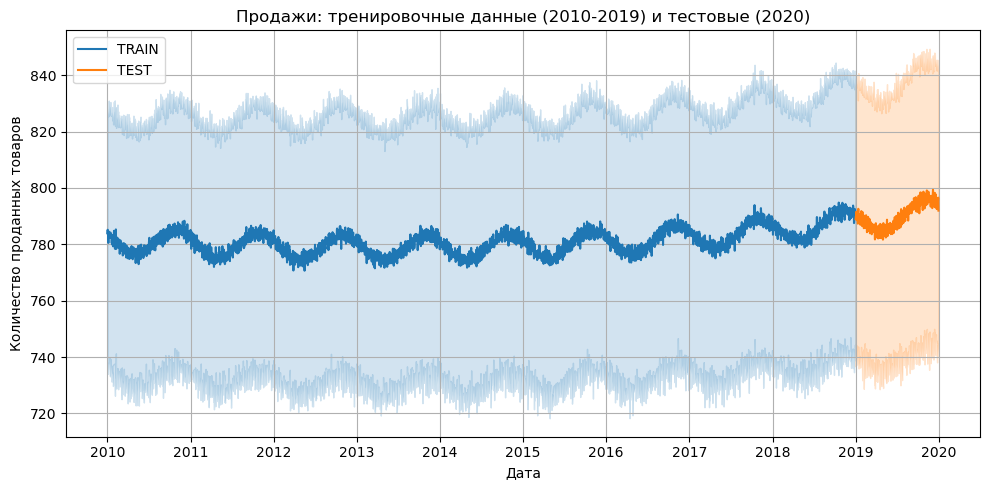

In [307]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=train, x='Date', y='number_sold', label='TRAIN')
sns.lineplot(data=test, x='Date', y='number_sold', label='TEST')
plt.title('Продажи: тренировочные данные (2010-2019) и тестовые (2020)')
plt.xlabel('Дата')
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.tight_layout()
plt.show()

Поменяем гранулярность на месячную. Возьмем среднее за месяц.

In [308]:
train_df = train.resample("ME").mean(numeric_only=True).dropna()
test_df = test.resample("ME").mean(numeric_only=True).dropna()

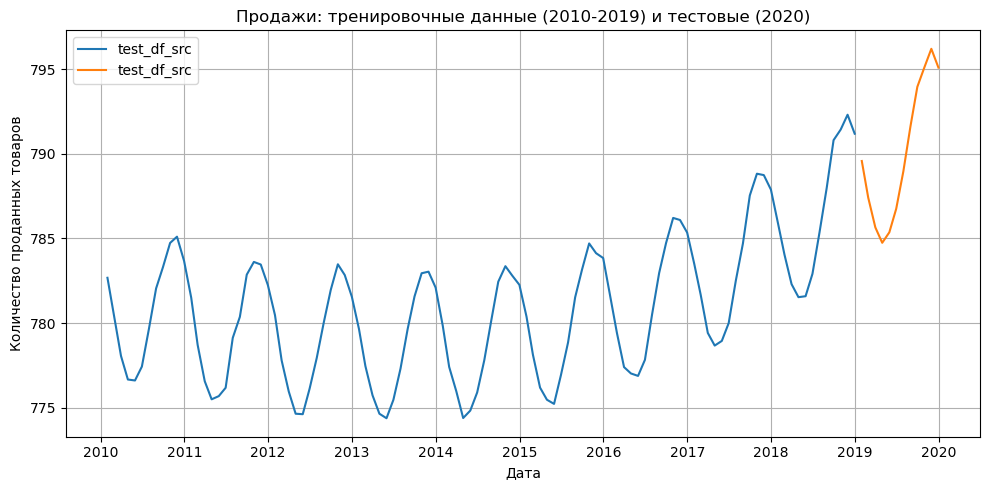

In [309]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=train_df, x='Date', y='number_sold', label='test_df_src')
sns.lineplot(data=test_df, x='Date', y='number_sold', label='test_df_src')
plt.title('Продажи: тренировочные данные (2010-2019) и тестовые (2020)')
plt.xlabel('Дата')
plt.ylabel('Количество проданных товаров')
plt.grid(True)
plt.tight_layout()
plt.show()

In [310]:
train_df.describe()

,number_sold
count,108.000000
mean,780.915886
std,4.149966
min,774.377419
25%,777.423954
50%,780.996544
75%,783.383763
max,792.304762


И тренд и сезонность явно присутствуют, о стационарности говорить не приходится.

Масштаб немного поменялся, данные сгладились, среднее значение сохранилось. количество "сезонных волн" сохранилось, что говорит о ярко выраженной сезонности. 

Даже невооруженным глазом видна 12 месячная сезонность. Исследуем эту гипотезу.

При смене гранулярности и сглаживаниях появляются промежутки, это не очень здорово, нужно будет учесть при прогнозировании и проверке. 

Отобразим скользящее среднее и стандартное отклонение с окном равным 3

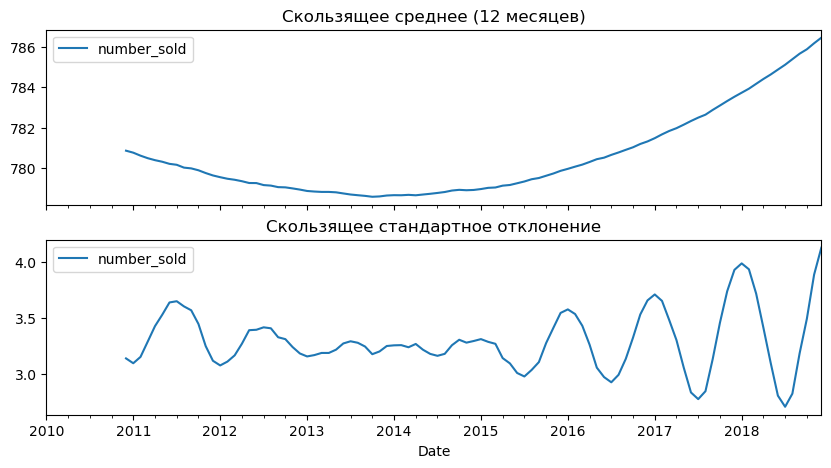

In [311]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)

rolling_mean = train_df.rolling(window=12).mean()
rolling_mean.plot(ax=axs[0])
axs[0].set_title('Скользящее среднее (12 месяцев)')

rolling_std = train_df.rolling(window=12).std()
rolling_std.plot(ax=axs[1])
axs[1].set_title('Скользящее стандартное отклонение');


Оба параметра имеют колебания.  

Скользящее среднее, отчетливо показывает нелинейность тренда.

Скользящее стандартное отклонение показывает превосходство влияния сезонности над влиянием тренда.

Проведем дифференцирование сезонности, и дифференцирование полиномиального тренда, затем сравним результаты ACF и PACF.

Первоначальный набор данных. И тест его стационарности
ADF: 1.336458, p-value: 0.996805
KPSS: 0.780901, p-value: 0.010000

Дифференциал первого порядка. И тест его стационарности
ADF: 1.096583, p-value: 0.995187
KPSS: 1.688672, p-value: 0.010000

Дифференциал второго порядка. И тест его стационарности
--------------------------------------------------
ADF Statistic: -4.545057, p-value: 0.000163
KPSS Statistic: 0.119195, p-value: 0.100000


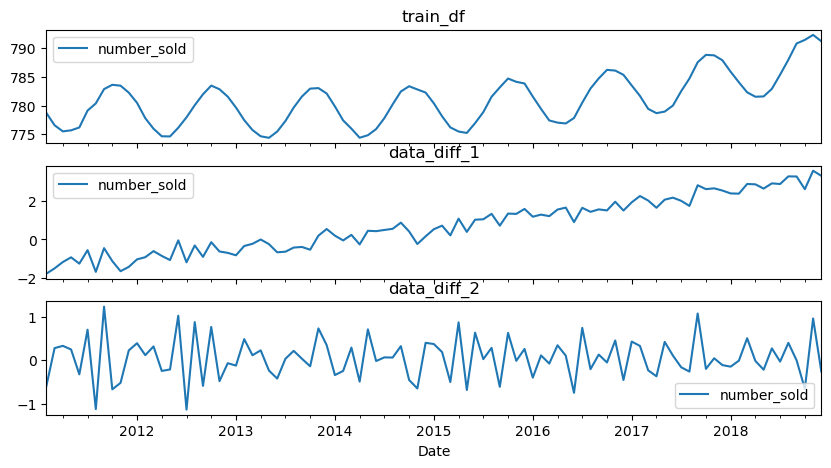

In [312]:
print('Первоначальный набор данных. И тест его стационарности')
adfuller_result = adfuller(train_df)
kpss_result = kpss(train_df)
print(f'ADF: {adfuller_result[0]:f}, p-value: {adfuller_result[1]:f}')
print(f'KPSS: {kpss_result[0]:f}, p-value: {kpss_result[1]:f}')

data_diff_1 = train_df.diff(12).dropna() #12-ти месячная сезонность

print('\nДифференциал первого порядка. И тест его стационарности')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data_diff_1)
print(f'ADF: {adfuller_result[0]:f}, p-value: {adfuller_result[1]:f}')
print(f'KPSS: {kpss_result[0]:f}, p-value: {kpss_result[1]:f}')

data_diff_2 = data_diff_1.diff(1).dropna()
print('\nДифференциал второго порядка. И тест его стационарности')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data_diff_2)
print(f'ADF Statistic: {adfuller_result[0]:f}, p-value: {adfuller_result[1]:f}')
print(f'KPSS Statistic: {kpss_result[0]:f}, p-value: {kpss_result[1]:f}')

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)
train_df.plot(ax=axs[0], title='train_df')
data_diff_1.plot(ax=axs[1], title='data_diff_1')
data_diff_2.plot(ax=axs[2], title='data_diff_2');

Отобразим графики автокорреляции и частичной автокорреляции ACF и PACF. Посмотрим, что сможем заметить на получившихся графиках.

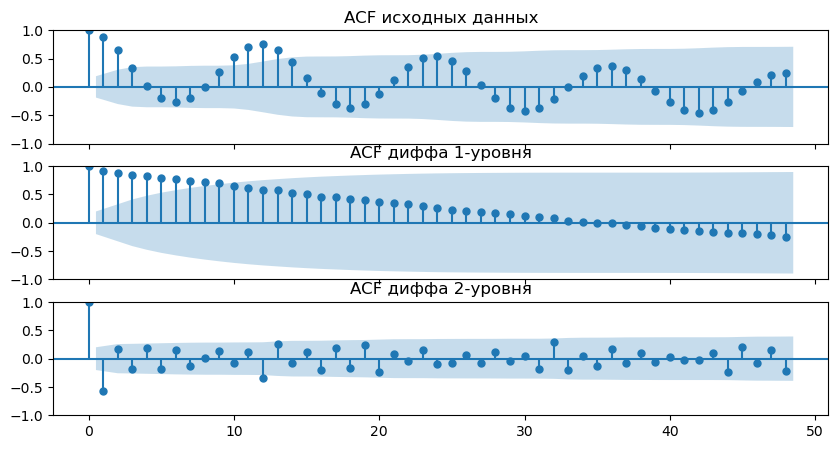

In [313]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)
plot_acf(train_df, ax=axs[0], lags=48, alpha=0.05)
axs[0].set_title('ACF исходных данных')
plot_acf(data_diff_1, ax=axs[1], lags=48, alpha=0.05)
axs[1].set_title('ACF диффа 1-уровня');
plot_acf(data_diff_2, ax=axs[2], lags=48, alpha=0.05)
axs[2].set_title('ACF диффа 2-уровня');

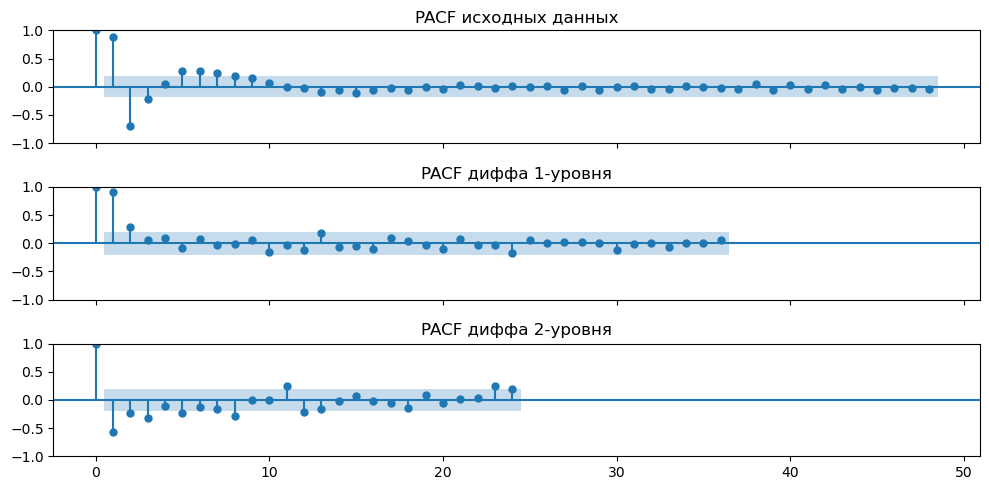

In [314]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)
plot_pacf(train_df, ax=axs[0], lags=48, alpha=0.05)
axs[0].set_title('PACF исходных данных')
plot_pacf(data_diff_1, ax=axs[1], lags=36, alpha=0.05)
axs[1].set_title('PACF диффа 1-уровня');
plot_pacf(data_diff_2, ax=axs[2], lags=24, alpha=0.05)
axs[2].set_title('PACF диффа 2-уровня');
plt.tight_layout();

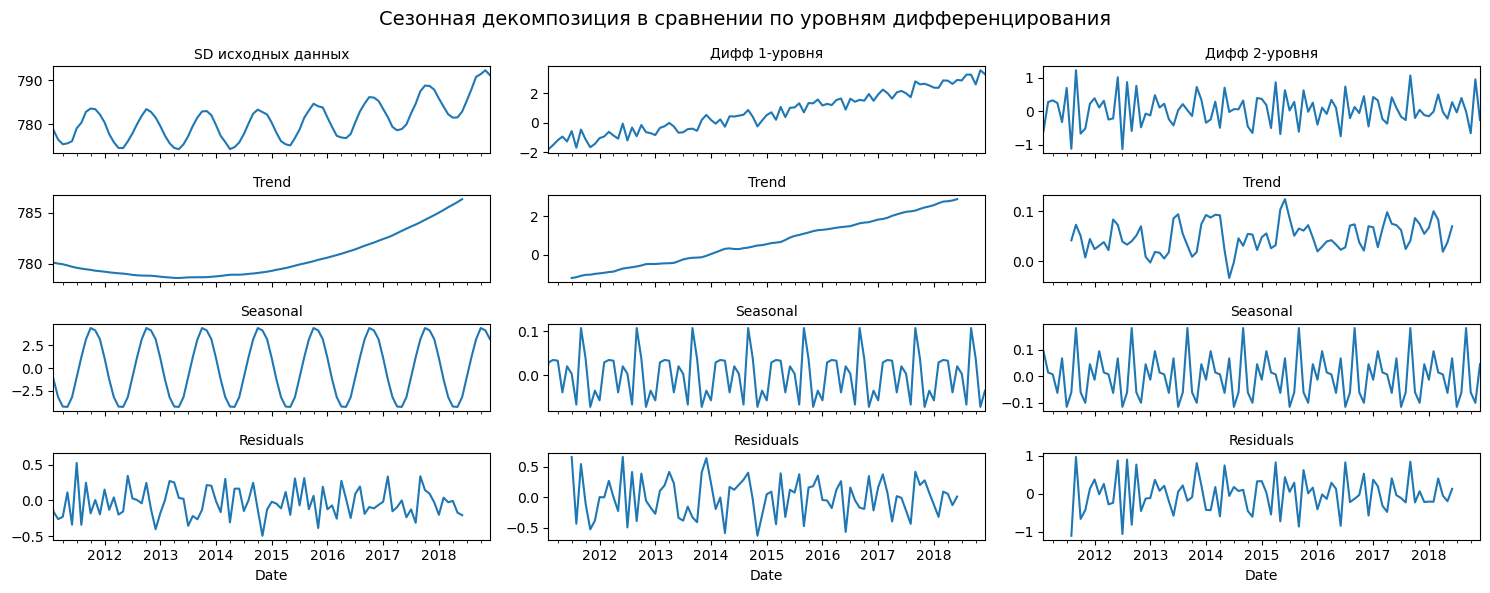

In [315]:
res_decompose = seasonal_decompose(train_df, model='additive')#, extrapolate_trend='freq')
res_descompose_diff_1 = seasonal_decompose(data_diff_1, model='additive')#, extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_2, model='additive')#, extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('SD исходных данных', fontsize=10)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=10)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=10)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=10)

res_descompose_diff_1.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Дифф 1-уровня', fontsize=10)
res_descompose_diff_1.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=10)
res_descompose_diff_1.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=10)
res_descompose_diff_1.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=10)

res_descompose_diff_2.observed.plot(ax=axs[0, 2])
axs[0, 2].set_title('Дифф 2-уровня', fontsize=10)
res_descompose_diff_2.trend.plot(ax=axs[1, 2])
axs[1, 2].set_title('Trend', fontsize=10)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 2])
axs[2, 2].set_title('Seasonal', fontsize=10)
res_descompose_diff_2.resid.plot(ax=axs[3, 2])
axs[3, 2].set_title('Residuals', fontsize=10)

fig.suptitle('Сезонная декомпозиция в сравнении по уровням дифференцирования', fontsize=14)
fig.tight_layout();

Получим итоговый комбинированный результат.

In [367]:
data_diff_1_12 = train_df.diff(12).diff(1).dropna()#.iloc[1:-1]

Выполним оценку стационарности комбинированного результата

In [368]:
adfuller_result = adfuller(data_diff_1_12)
print(f'ADF: {adfuller_result[0]:f}, p-value: {adfuller_result[1]:f}')
kpss_result = kpss(data_diff_1_12)
print(f'KPSS: {kpss_result[0]:f}, p-value: {kpss_result[1]:f}')

ADF: -4.545057, p-value: 0.000163
KPSS: 0.119195, p-value: 0.100000


#### ARIMA-модель из pdmarima

In [369]:
model_1 = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_1.fit(y=train_df)
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -19.261
Date:                             Сб, 10 май 2025   AIC                             50.522
Time:                                    11:41:01   BIC                             65.845
Sample:                                01-31-2010   HQIC                            56.714
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0454      0.013      3.463      0.001       0.020       0.071
ar.L1         -0.1151      0.126     -0.915      0.360      -0.362       0.131
ma.L1         -0.8250      0.109     -7.554      0.000      -1.039      -0.611
ar.S.L12       0.1758      0.178      0.986      0.324      -0.174       0.525
ma.S.L12      -0.9491      0.737     -1.287      0.198      -2.394       0.496
sigma2         0.0717      0.045      1.597      0.110      -0.016       0.160
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.31
Prob(Q):                              1.00   Prob(JB):                         0.86
Heteroskedasticity (H):               0.54   Skew:                            -0.07
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA-модель из statsmodels

In [370]:
model_2 = SARIMAX(endog = train_df, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res_2 = model_2.fit(disp=0)
model_res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        number_sold   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -38.849
Date:                             Сб, 10 май 2025   AIC                             87.699
Time:                                    11:41:01   BIC                            100.468
Sample:                                01-31-2010   HQIC                            92.859
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3479      0.191     -1.824      0.068      -0.722       0.026
ma.L1         -0.2575      0.225     -1.143      0.253      -0.699       0.184
ar.S.L12      -0.0667      0.359     -0.186      0.853      -0.770       0.636
ma.S.L12      -0.3224      0.362     -0.892      0.373      -1.031       0.386
sigma2         0.1295      0.023      5.612      0.000       0.084       0.175
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.14   Prob(JB):                         0.41
Heteroskedasticity (H):               0.78   Skew:                            -0.28
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Сверим с автоподбором от pdarima

In [371]:
from pmdarima import auto_arima

model = auto_arima(
    train_df,
    seasonal=True, m=12,  # s=12 (месячные данные)
    stepwise=True,
    trace=True  # Логи подбора
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=90.838, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=129.827, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=88.380, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=87.646, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=92.330, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=89.499, Time=0.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=89.164, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=88.321, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=89.717, Time=0.48 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=111.619, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=85.769, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=91.928, Time=0.03 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=87.699, Time=0.17 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=87.586, Time=0.23 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=87

Автоподбор предлагает *ARIMA(1,1,0)(0,1,1)[12]* и *SARIMAX(1, 1, 0)x(0, 1, [1], 12)* - попробуем

In [372]:
model_1b = ARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model_1b.fit(y=train_df)
model_1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -28.608
Date:                               Сб, 10 май 2025   AIC                             65.216
Time:                                      11:41:06   BIC                             75.431
Sample:                                  01-31-2010   HQIC                            69.344
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0815      0.012      6.640      0.000       0.057       0.106
ar.L1         -0.6023      0.084     -7.148      0.000      -0.767      -0.437
ma.S.L12      -0.9914      3.670     -0.270      0.787      -8.184       6.201
sigma2         0.0815      0.291      0.280      0.779      -0.489       0.652
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.18   Prob(JB):                         0.67
Heteroskedasticity (H):               0.65   Skew:                            -0.19
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [373]:
model_2b = SARIMAX(endog = train_df, order = (1, 1, 0), seasonal_order = (0, 1, 1, 12))
model_res_2b = model_2b.fit(disp=0)
model_res_2b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          number_sold   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -39.495
Date:                               Сб, 10 май 2025   AIC                             84.991
Time:                                      11:41:06   BIC                             92.652
Sample:                                  01-31-2010   HQIC                            88.087
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5229      0.086     -6.074      0.000      -0.692      -0.354
ma.S.L12      -0.4512      0.119     -3.786      0.000      -0.685      -0.218
sigma2         0.1302      0.023      5.645      0.000       0.085       0.175
===================================================================================
Ljung-Box (L1) (Q):                   3.01   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.08   Prob(JB):                         0.38
Heteroskedasticity (H):               0.80   Skew:                            -0.31
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

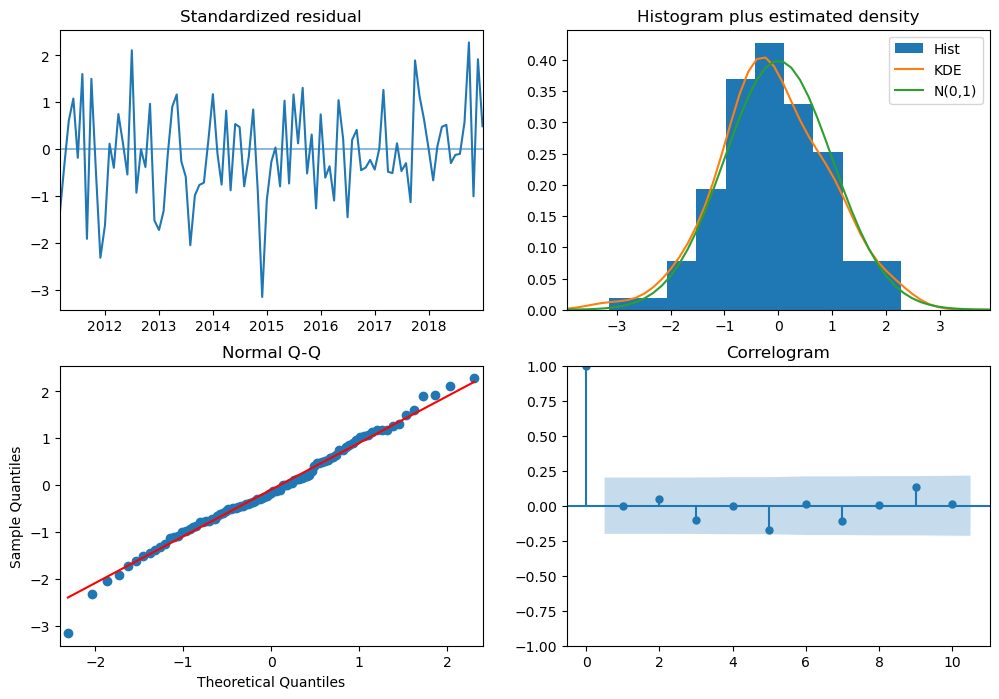

In [374]:
model_1.plot_diagnostics(figsize=(12, 8))
plt.show()

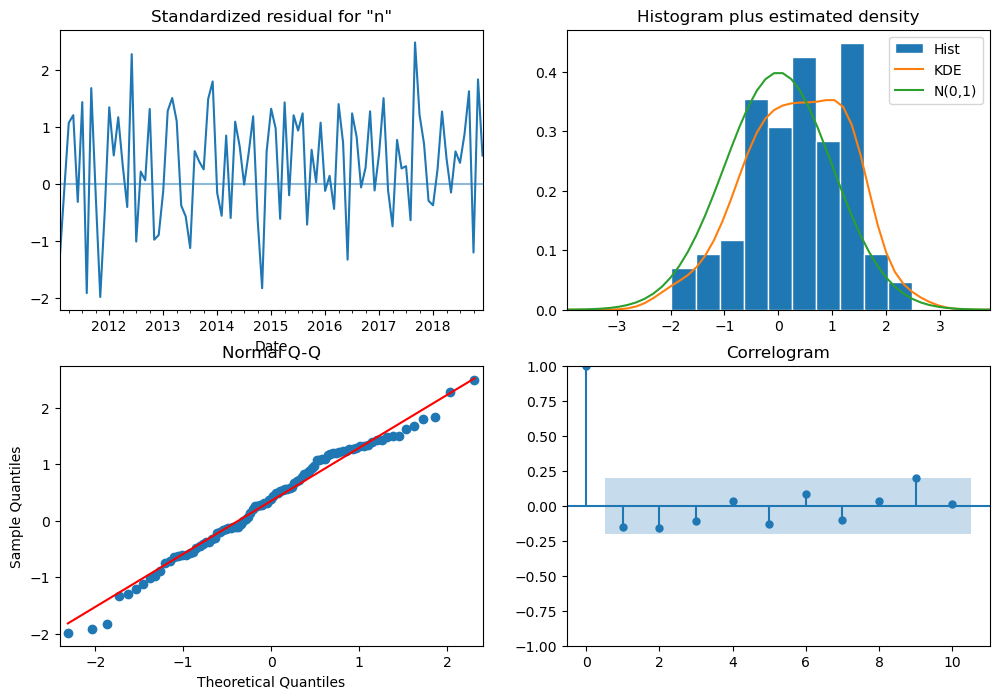

In [375]:
model_res_2.plot_diagnostics(figsize=(12, 8))
plt.show()

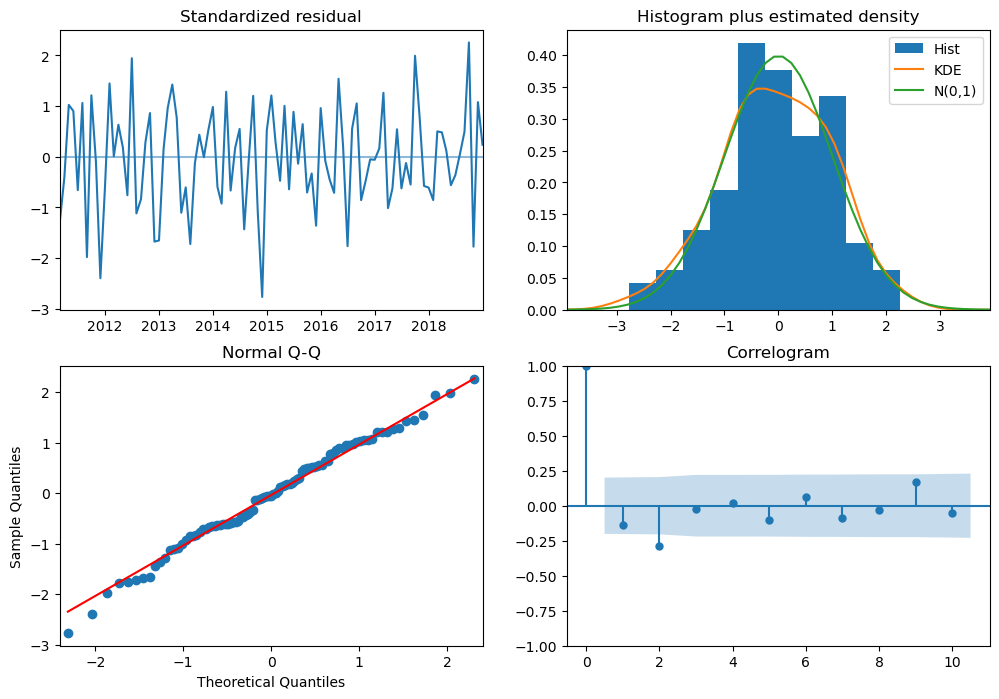

In [376]:
model_1b.plot_diagnostics(figsize=(12, 8))
plt.show()

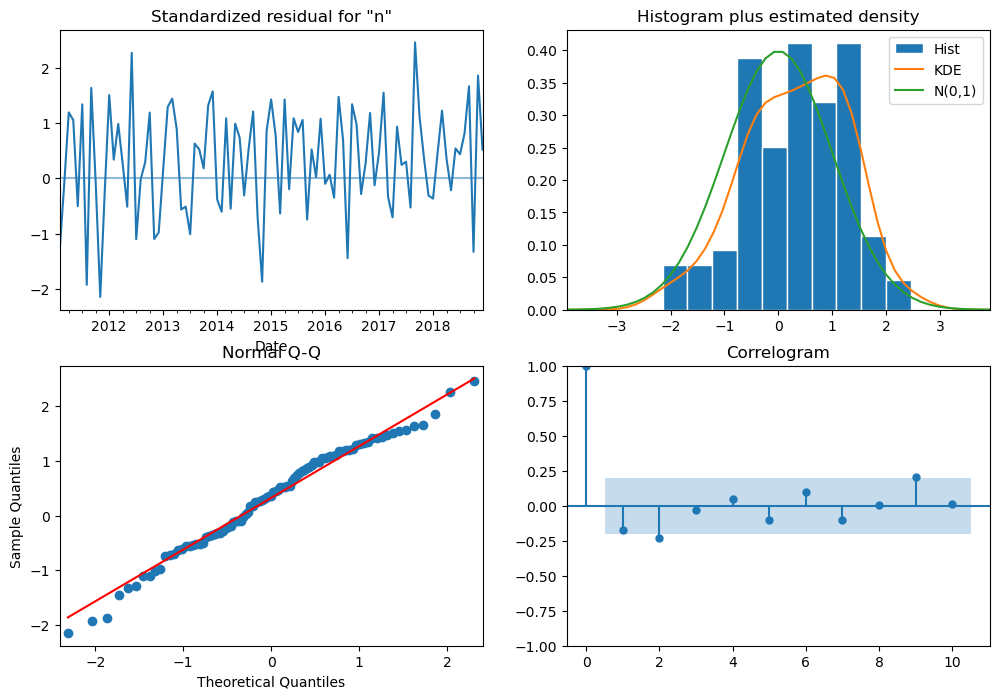

In [377]:
model_res_2b.plot_diagnostics(figsize=(12, 8))
plt.show()

Пора обратиться к результатам предсказаний наших моделей.

In [385]:
predictions_1 = model_1.predict(len(test_df))
predictions_1.name = 'arima'

predictions_2 = model_res_2.get_forecast(steps=len(test_df)).predicted_mean
predictions_2.name = 'sarima'

predictions_1b = model_1b.predict(len(test_df))
predictions_1b.name = 'arima_b'

predictions_2b = model_res_2b.get_forecast(steps=len(test_df)).predicted_mean
predictions_2b.name = 'sarima_b'

Отразим все полученные предсказания на фоне тестовых значений для более наглядного сопоставления.

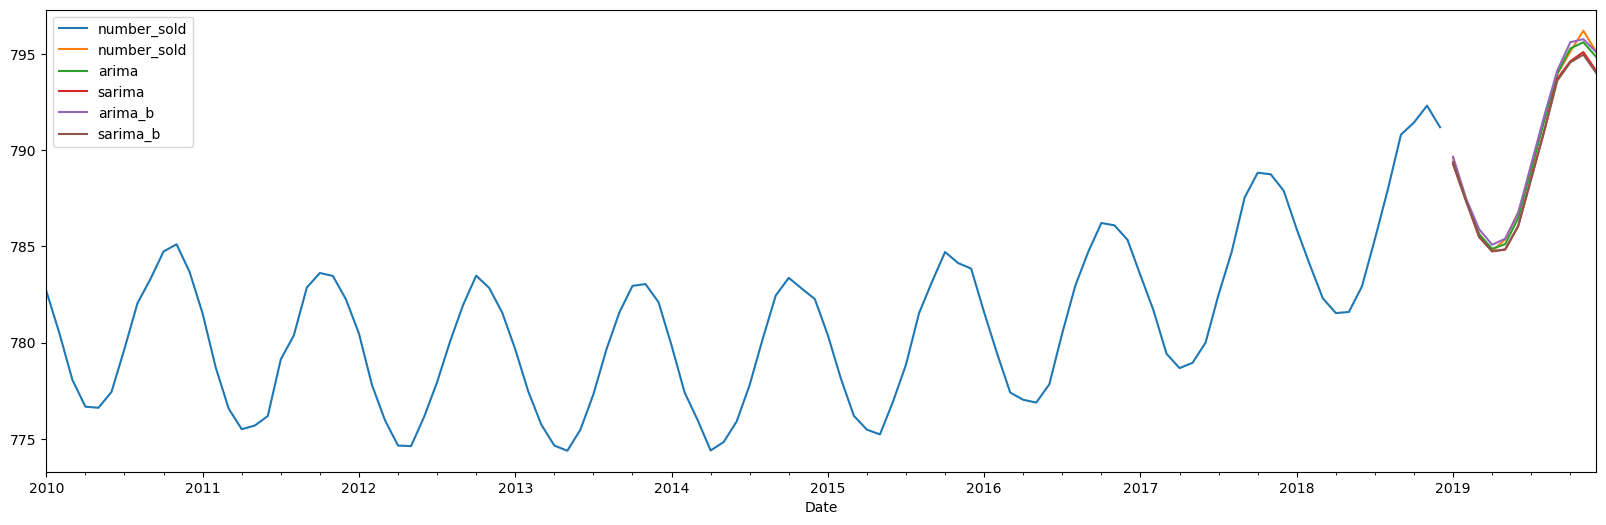

In [379]:
fig, ax = plt.subplots(figsize=(20, 6))
train_df.plot(ax=ax, label='train')
test_df.plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label=predictions_1.name)
predictions_2.plot(ax=ax, label=predictions_2.name)
predictions_1b.plot(ax=ax, label=predictions_1b.name)
predictions_2b.plot(ax=ax, label=predictions_2b.name)
ax.legend();

Казалось бы, половина дела сделана, предсказания получены, осталось выполнить оценки, и выбрать лучшее.

Найдено выбросов: 11

Shapiro-Wilk test results:
W: 0.1311168060766973, p-value: 2.175215389940915e-22

Ljung-Box: все значения p-value > 0.05. нет автокорреляции


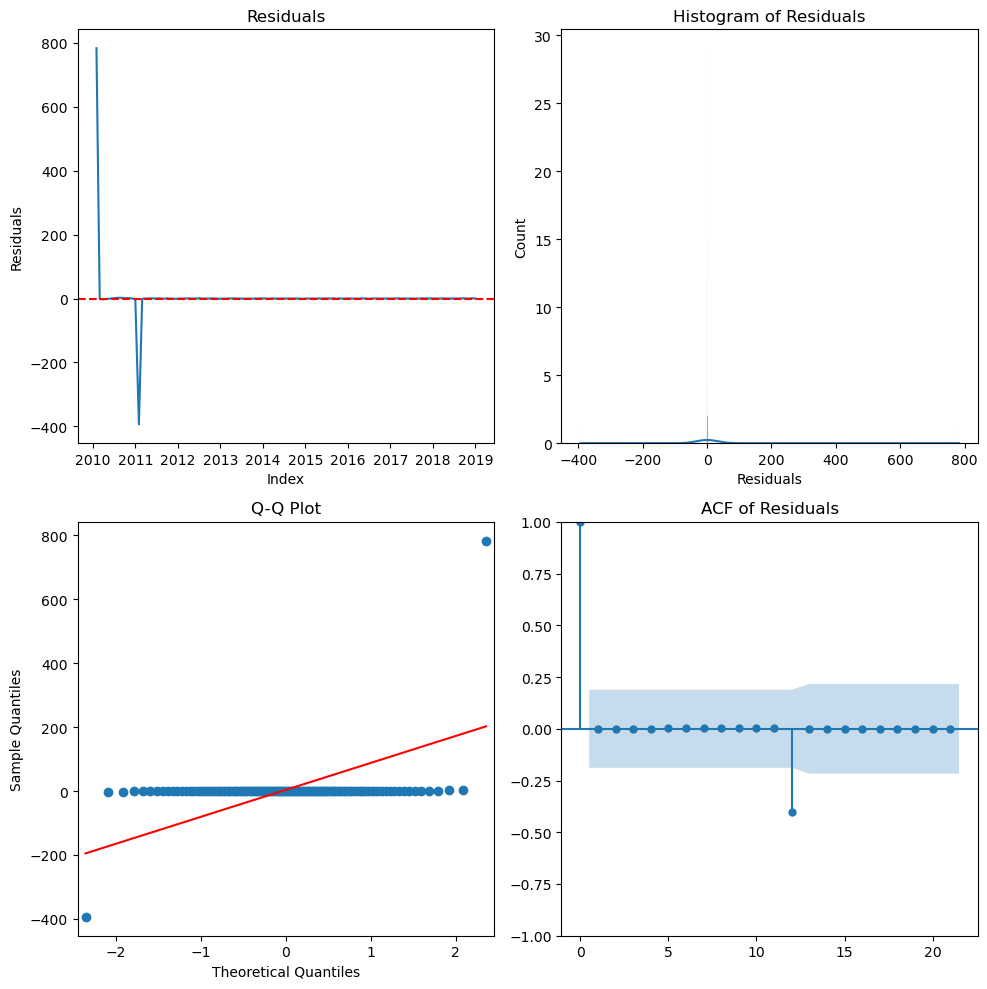

------------------------------
Найдено выбросов: 10

Shapiro-Wilk test results:
W: 0.13132505584892362, p-value: 2.186585873801482e-22

Ljung-Box: все значения p-value > 0.05. нет автокорреляции


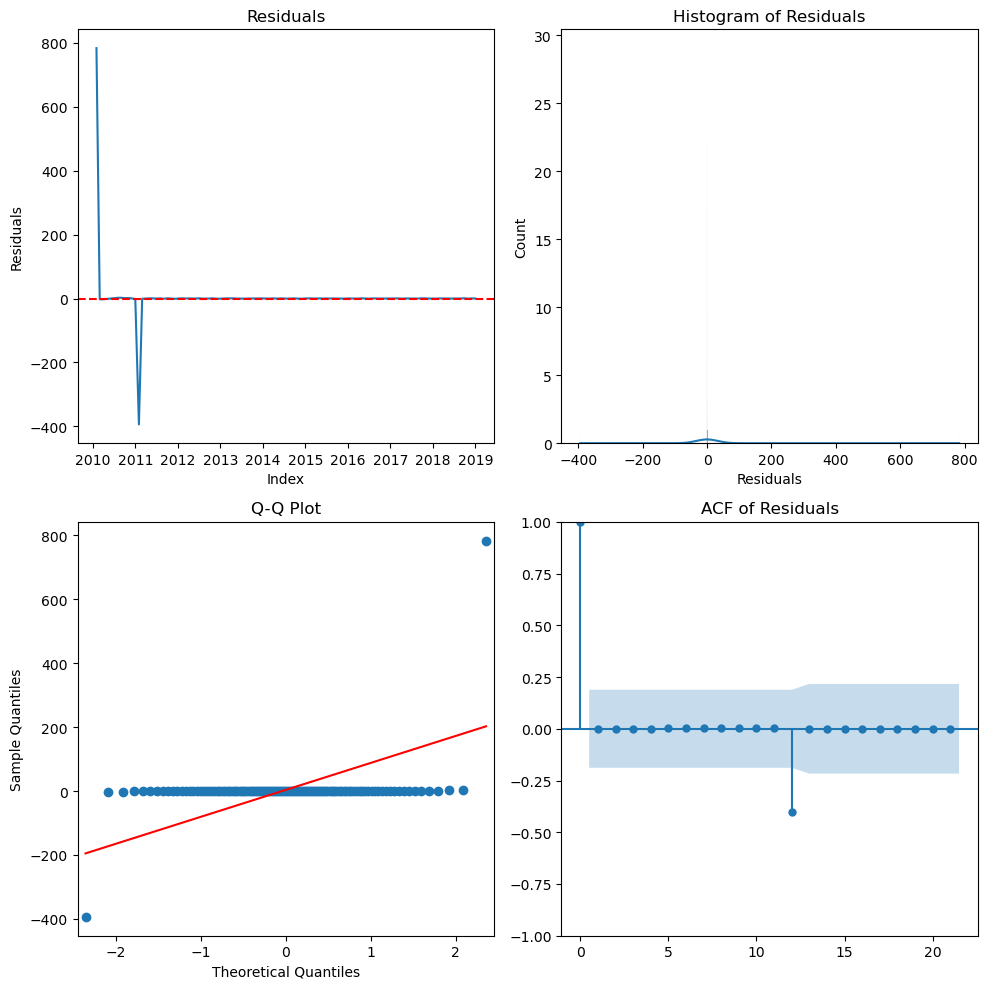

------------------------------
Найдено выбросов: 10

Shapiro-Wilk test results:
W: 0.13139898521242233, p-value: 2.190637222722874e-22

Ljung-Box: все значения p-value > 0.05. нет автокорреляции


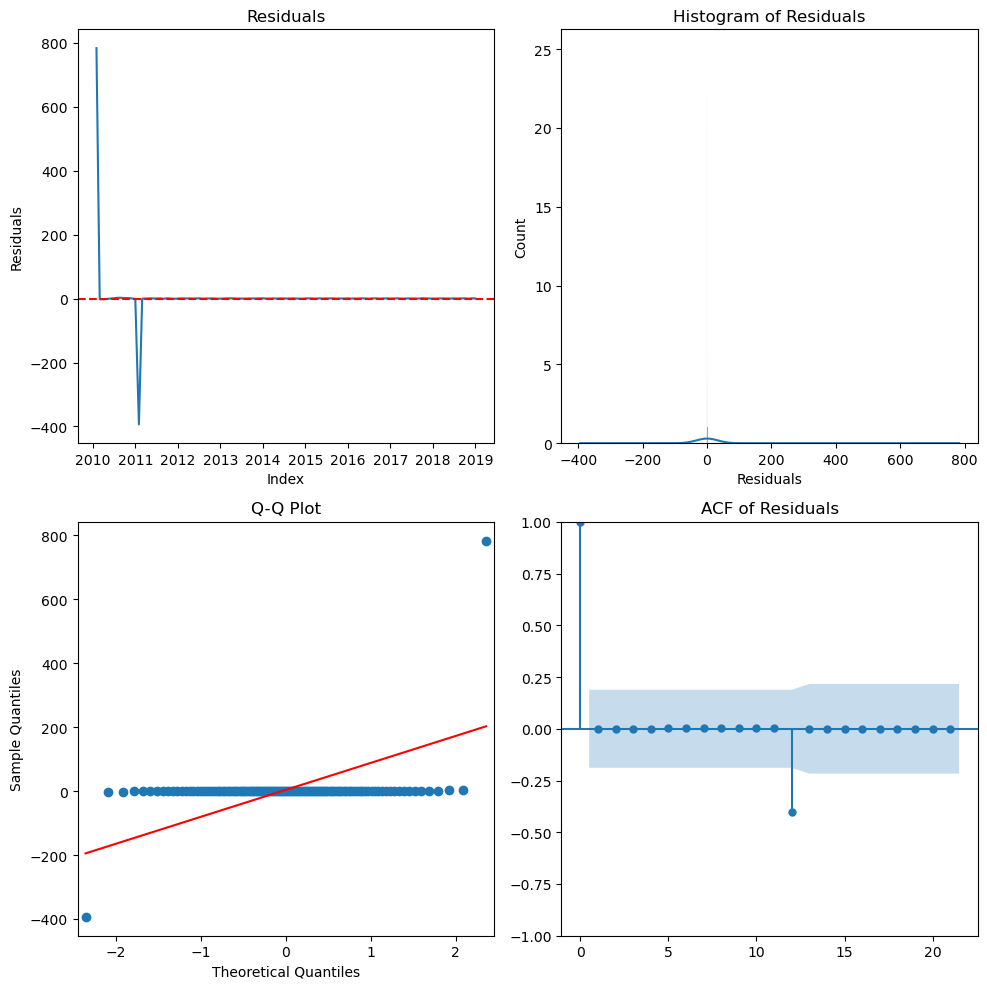

------------------------------
Найдено выбросов: 10

Shapiro-Wilk test results:
W: 0.13139898521242233, p-value: 2.190637222722874e-22

Ljung-Box: все значения p-value > 0.05. нет автокорреляции


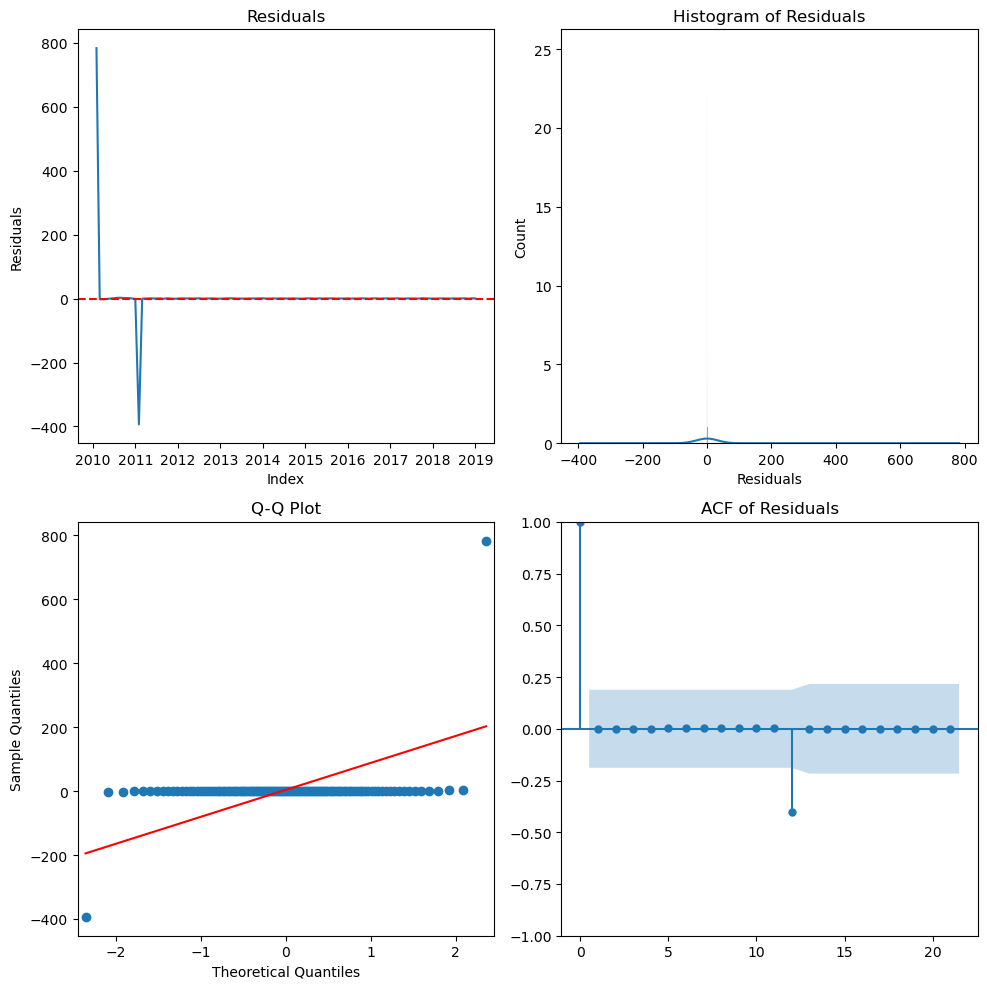

------------------------------


In [380]:
import statsmodels.api as sm
resid_1 = model_1.resid()
resid_1.name = 'arima'

resid_1b = model_1b.resid()
resid_1b.name = 'arima_b'

resid_2 = model_res_2.resid
resid_2.name = 'sarima'

resid_2b = model_res_2b.resid
resid_2b.name = 'sarima_b'

models_residuals = [resid_1, resid_1b, resid_2b, resid_2b]
for rsd in models_residuals:

    q1 = rsd.quantile(0.25)
    q3 = rsd.quantile(0.75)
    iqr = q3 - q1
    outliers = rsd[(rsd < (q1 - 1.5*iqr)) | (rsd > (q3 + 1.5*iqr))]
    print(f'Найдено выбросов: {len(outliers)}')

    shapiro_test = shapiro(rsd)
    print(f"\nShapiro-Wilk test results:\nW: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

    if shapiro_test[1] > 0.05:
        print(f'p-value: {shapiro_test[1]} > 0.05 - нормальность')

    lb_test = acorr_ljungbox(rsd)
    if (lb_test['lb_pvalue'] > 0.05).all():
         print(f'\nLjung-Box: все значения p-value > 0.05. нет автокорреляции')
    else:
        print(lb_test)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(rsd)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals')
    plt.xlabel('Index')
    plt.ylabel('Residuals')

    # 2. Гистограмма остатков
    plt.subplot(2, 2, 2)
    sns.histplot(rsd, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')

    # 3. Q-Q plot для проверки нормальности
    plt.subplot(2, 2, 3)
    sm.qqplot(rsd, line='s', ax=plt.gca())
    plt.title('Q-Q Plot')

    # 4. ACF Plot для проверки автокорреляции остатков
    plt.subplot(2, 2, 4)
    plot_acf(rsd, ax=plt.gca())
    plt.title('ACF of Residuals')

    plt.tight_layout()
    plt.show()
    print('------------------------------')


Оценки остатков вызывают определеннное недоумение. Вероятно искусственная природа формирования значений дала о себе знать.

Возможно гранулярность критически упростила модель, и нужно изменить гранулярность до менее предсказуемых значений. 

Или в предоставленных данных явно присутствуют сложные зависимости, которые не были учтены при первоначальной декомпозиции.

#### Оценка качества

In [381]:
pr_list = [predictions_1, predictions_1b, predictions_2, predictions_2b]

for pr in pr_list:
    mape = mean_absolute_percentage_error(test_df, pr)
    rmse = np.sqrt(mean_squared_error(test_df, pr))
    r2 = r2_score(test_df, pr)
    print(f"\nModel: {pr.name}")
    print(f"MAPE: {mape:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}")



Model: arima
MAPE: 0.0002
RMSE: 0.24
R2: 0.9964

Model: arima_b
MAPE: 0.0002
RMSE: 0.25
R2: 0.9961

Model: sarima
MAPE: 0.0006
RMSE: 0.57
R2: 0.9797

Model: sarima_b
MAPE: 0.0006
RMSE: 0.62
R2: 0.9765


Совершенно идеальную картину показывают метрики MAPE, RMSE и R2.

Модели ARIMA и  SARIMA с такими метриками работают практически безупречно на предоставленных данных.
Средняя ошибка прогноза составляет 0.02% от фактических значений.
Для временного ряда где значения ~800, RMSE=0.25 - мизерная погрешность.
Значение R² > 0.99 указывают на идеальное соответствие модели данным.



# Вывод

В данной работе мы научились формировать модели ARIMA и SARIMA,подбирать их параметры, 
оценивать показатели прогнозирования и получать результаты прогноза, с достаточно высокими результатами качества.